Mostly following
- https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
- https://github.com/AKASHKADEL/dcgan-mnist

Imports

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

from models.discriminator import Discriminator
from models.generator import Generator

Set device to GPU (cuda) if available

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Download mnist dataset

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))])

train_dataset = datasets.MNIST(
    root='data',
    train=True,
    transform=transform,
    download=False,
)
test_dataset = datasets.MNIST(
    root='data',
    train=False,
    transform=ToTensor()
)

Print some datapoints using matplotlib

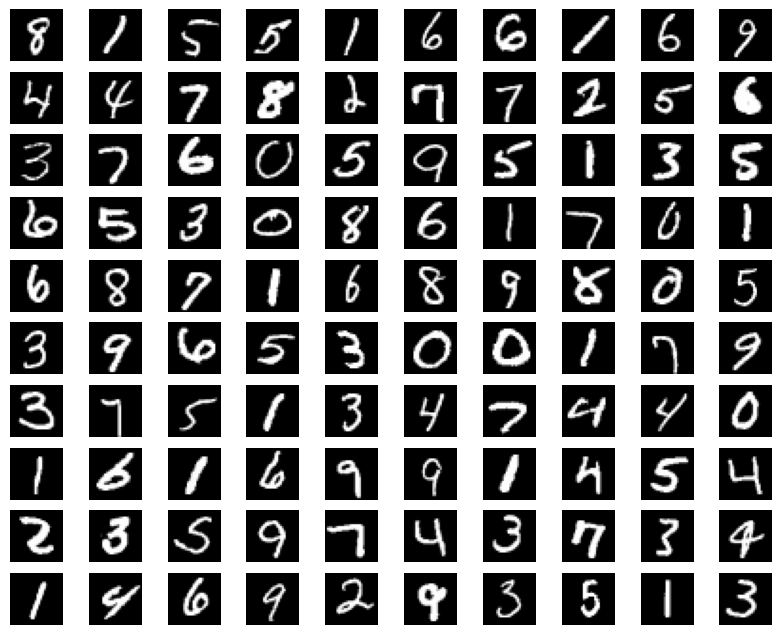

In [5]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 10, 10
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Set hyperparameter and load datasets into pytorch DataLoader. This allows to batch data and shuffle after each epoch. It also allows using multiple processors and load data directly into CUDA tensors.

In [6]:
batch_size = 128
num_classes = 10
learning_rate = 0.002
num_epochs = 5
num_color_channels = 1
num_feature_maps_g = 32
num_feature_maps_d = 32
size_z = 100
adam_beta1 = 0.2
num_gpu = 0

dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

Load Generator (CNN) class

In [7]:
generator = Generator(size_z=size_z,
                      num_feature_maps=num_feature_maps_g,
                      num_color_channels=num_color_channels).to(device)

Load Discriminator (CNN) class

In [8]:
discriminator = Discriminator(num_feature_maps=num_feature_maps_d,
                              num_color_channels=num_color_channels).to(device)

loss function and optimization functions

In [9]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(16, size_z, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizerG = optim.Adam(generator.parameters(), lr=learning_rate, betas=(adam_beta1, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(adam_beta1, 0.999))

Training function

In [10]:
print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        #get batch-size
        bs = real_images.shape[0]

        #train discriminator

        # reset discriminators gradient
        discriminator.zero_grad()

        #move images to either CPU or GPU
        real_images = real_images.to(device)

        #?
        label = torch.full((bs,), real_label, device=device)

        #get probs for discriminators guess on the real images
        output = discriminator(real_images)

        #get loss for real images
        lossD_real = criterion(output, label)

        #adjust parameter to identify real images
        lossD_real.backward()

        #?
        D_x = output.mean().item()

        #create noise as an input for the G in order to create fake images
        noise = torch.randn(bs, size_z, 1, 1, device=device)

        #use generator to map input noise to an output that is supposed do become fake images during training
        fake_images = generator(noise)

        #?
        label.fill_(fake_label)

        #get discriminators guess on fake images
        output = discriminator(fake_images.detach())

        #get loss for fake images
        lossD_fake = criterion(output, label)

        #adjust parameter to identify fakes
        lossD_fake.backward()

        #?
        D_G_z1 = output.mean().item()

        #calculate loss
        lossD = lossD_real + lossD_fake
        optimizerD.step()

        #train generator

        generator.zero_grad()
        label.fill_(real_label)
        output = discriminator(fake_images)
        lossG = criterion(output, label)
        lossG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if (i + 1) % 100 == 0:
            print(
                'Epoch [{}/{}], step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, Discriminator - D(G(x)): {:.2f}, Generator - D(G(x)): {:.2f}'
                .format(
                    epoch + 1,
                    num_epochs,
                    i + 1,
                    batch_size,
                    lossD.item(),
                    lossG.item(),
                    D_x,
                    D_G_z1,
                    D_G_z2
                )
            )
    generator.eval()
    generator.train()

Starting Training Loop...
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128


KeyboardInterrupt: 

In [ ]:
torch.save(generator.state_dict(), 'model.ckpt')